<a href="https://colab.research.google.com/github/MM24J/FinAssist/blob/main/notebooks/FinAssist_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# FinAssist Repo
import os

REPO_URL = "https://github.com/MM24J/FinAssist.git"
REPO_PATH = "/content/FinAssist"

# Clone if missing
if not os.path.exists(REPO_PATH):
    !git clone {REPO_URL} {REPO_PATH}

# Enter repo and pull latest
%cd {REPO_PATH}
!git pull origin main

# Show structure
print("\n Repo contents:")
!ls -l
print("\n Data folder:")
!ls -l data || echo " Missing data folder"
print("\n Notebooks folder:")
!ls -l notebooks || echo " Missing notebooks folder"

# Default to notebooks folder
%cd notebooks

/content/FinAssist
From https://github.com/MM24J/FinAssist
 * branch            main       -> FETCH_HEAD
Already up to date.

 Repo contents:
total 20
drwxr-xr-x 2 root root 4096 Aug 29 02:39 data
drwxr-xr-x 3 root root 4096 Aug 29 02:40 finassist
drwxr-xr-x 2 root root 4096 Aug 29 02:41 kb
drwxr-xr-x 3 root root 4096 Aug 29 02:41 notebooks
-rw-r--r-- 1 root root   11 Aug 29 02:39 README.md

 Data folder:
total 56
-rw-r--r-- 1 root root   332 Aug 29 02:39 Budget.csv
-rw-r--r-- 1 root root 50598 Aug 29 02:39 personal_transactions.csv

 Notebooks folder:
total 272
-rw-r--r-- 1 root root 275346 Aug 29 02:39 FinAssist_Project.ipynb
/content/FinAssist/notebooks


In [ ]:
#!pip -q install sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 42.1 MB/s eta 0:00:00


## About the Data  

The budgeting and spending data used in this project comes from a **public Kaggle dataset**.  
https://www.kaggle.com/datasets/bukolafatunde/personal-finance/data

Key points:  
- The dataset includes **monthly budget vs. actual expenses** across categories such as Rent, Utilities, Restaurants, Entertainment, and more.  
- No demographic or household details are provided. Based on the format, it appears to represent **one individual’s anonymized finances** rather than aggregated statistics.  
- Because of this, results and insights are **illustrative only** and should not be generalized to broader populations.  
- We use it as a structured example to demonstrate budgeting analysis, variance detection, and retrieval-augmented generation (RAG) for financial guidance.  


In [ ]:
import pandas as pd
import numpy as np

# Correct path to data files
budget = pd.read_csv("../data/Budget.csv")
tx = pd.read_csv("../data/personal_transactions.csv", parse_dates=["Date"])

# Normalize helpers
tx["Type"] = np.where(tx["Amount"] >= 0, "Income", "Expense")
tx["Spend"] = tx["Amount"].where(tx["Amount"] < 0, 0).abs()
tx["Month"] = tx["Date"].dt.to_period("M").astype(str)

budget.head(), tx.head()

(                 Category  Budget
 0          Alcohol & Bars      50
 1          Auto Insurance      75
 2            Coffee Shops      15
 3  Electronics & Software       0
 4           Entertainment      25,
         Date          Description   Amount Transaction Type  \
 0 2018-01-01               Amazon    11.11            debit   
 1 2018-01-02     Mortgage Payment  1247.44            debit   
 2 2018-01-02      Thai Restaurant    24.22            debit   
 3 2018-01-03  Credit Card Payment  2298.09           credit   
 4 2018-01-04              Netflix    11.76            debit   
 
               Category   Account Name    Type  Spend    Month  
 0             Shopping  Platinum Card  Income    0.0  2018-01  
 1      Mortgage & Rent       Checking  Income    0.0  2018-01  
 2          Restaurants    Silver Card  Income    0.0  2018-01  
 3  Credit Card Payment  Platinum Card  Income    0.0  2018-01  
 4        Movies & DVDs  Platinum Card  Income    0.0  2018-01  )

In [ ]:
# Normalize case spaces in Transaction Type column

tx["Transaction Type"] = tx["Transaction Type"].str.strip().str.lower()

# Drop categories categories not in "Budget" CSV

EXCLUDE_CATS = {"Food & Dining", "Paycheck", "Credit Card Payment"}
tx = tx[~tx["Category"].isin(EXCLUDE_CATS)]

# Use transaction type to determine spend

tx["Spend"] = np.where(tx["Transaction Type"] == "debit", tx["Amount"].astype(float), 0.0)
tx["Income"] = np.where(tx["Transaction Type"] == "credit", tx["Amount"].astype(float), 0.0)

# Month Helper

tx["Month"] = tx["Date"].dt.to_period("M").astype(str)

# Check which months have spend

month_spend = tx.groupby("Month")["Spend"].sum().sort_index()
print(month_spend.tail(12))

Month
2018-10     2227.62
2018-11     2118.15
2018-12     2589.94
2019-01     1736.43
2019-02     1954.60
2019-03     2142.59
2019-04     1966.87
2019-05     2253.41
2019-06    10912.38
2019-07     2551.12
2019-08     2043.20
2019-09     2038.28
Name: Spend, dtype: float64


In [ ]:
print(set(tx["Category"]))

{'Coffee Shops', 'Movies & DVDs', 'Utilities', 'Music', 'Entertainment', 'Restaurants', 'Mobile Phone', 'Haircut', 'Internet', 'Shopping', 'Fast Food', 'Alcohol & Bars', 'Auto Insurance', 'Mortgage & Rent', 'Groceries', 'Electronics & Software', 'Television', 'Gas & Fuel', 'Home Improvement'}


In [ ]:
# Data Overview

from datetime import datetime

def dataset_overview(tx: pd.DataFrame, budget: pd.DataFrame):
    # Dates & months
    tx_dates = tx["Date"].dropna()
    start = tx_dates.min()
    end = tx_dates.max()
    n_months = tx["Month"].nunique()

    # Counts
    n_tx = len(tx)
    cats_tx = set(tx["Category"].unique())
    cats_budget = set(budget["Category"].unique())
    overlap = cats_tx & cats_budget

    only_in_tx = sorted(cats_tx - cats_budget)
    only_in_budget = sorted(cats_budget - cats_tx)

    # Pretty print
    print(f"Date range: {start:%Y-%m-%d} → {end:%Y-%m-%d}  ({n_months} months)")
    print(f"Transactions: {n_tx:,}")
    print(f"Categories — tx: {len(cats_tx)}, budget: {len(cats_budget)}, overlap: {len(overlap)}")
    if only_in_tx:
        print("Only in transactions (excluded):", ", ".join(only_in_tx))
    if only_in_budget:
        print("In budget but no actuals (overall):", ", ".join(only_in_budget))

dataset_overview(tx, budget)

Date range: 2018-01-01 → 2019-09-30  (21 months)
Transactions: 615
Categories — tx: 19, budget: 19, overlap: 19


In [ ]:
# Monthly Budget Report Header

from datetime import datetime

def human_month(ym):  # "2019-09" -> "September 2019"
    return datetime.strptime(ym, "%Y-%m").strftime("%B %Y")

def month_report(month: str):
    # Sum up actual spend by category for the chosen month
    actuals = (tx[tx["Month"] == month]
               .groupby("Category", as_index=False)["Spend"].sum()
               .rename(columns={"Spend": "Actual"}))

    # Merge with budget and compute variance
    rep = (budget.merge(actuals, on="Category", how="left")
                  .fillna({"Actual": 0.0}))
    rep["Variance"] = rep["Actual"] - rep["Budget"]
    return rep.sort_values("Variance", ascending=False)

# Example use
rep = month_report("2019-09")
display(rep.head(10))
print(f"Total spend in {human_month('2019-09')}: ${rep['Actual'].sum():,.2f}")

,Category,Budget,Actual,Variance
0,Alcohol & Bars,50,72.98,22.98
15,Restaurants,150,172.34,22.34
1,Auto Insurance,75,75.00,0.00
12,Mortgage & Rent,1100,1100.00,0.00
3,Electronics & Software,0,0.00,0.00
11,Mobile Phone,65,65.00,0.00
10,Internet,75,75.00,0.00
13,Movies & DVDs,0,0.00,0.00
14,Music,11,10.69,-0.31
17,Television,15,13.90,-1.10


Total spend in September 2019: $2,038.28


In [ ]:
# Over/Under Budget Summary

from datetime import datetime

def human_month(ym: str) -> str:
    # If it's already human (e.g., "September 2019"), just return it
    try:
        return datetime.strptime(ym, "%Y-%m").strftime("%B %Y")
    except Exception:
        return ym

def budget_summary(rep, top=5, month_label="(month)"):
    over = rep[rep["Variance"] > 0].sort_values("Variance", ascending=False).head(top)
    under = rep[rep["Variance"] < 0].sort_values("Variance", ascending=True).head(top)

    print(f"--- Budget Summary for {month_label} ---\n")
    print(f"Top {len(over)} over-budget categories:")
    for r in over.itertuples():
        print(f"  - {r.Category}: +${r.Variance:,.2f} "
              f"(Actual ${r.Actual:,.2f} vs Budget ${r.Budget:,.2f})")

    print(f"\nTop {len(under)} under-budget categories:")
    for r in under.itertuples():
        print(f"  - {r.Category}: ${r.Variance:,.2f} "
              f"(Actual ${r.Actual:,.2f} vs Budget ${r.Budget:,.2f})")

In [ ]:
rep = month_report("2019-09")
budget_summary(rep, month_label="September 2019")

--- Budget Summary for September 2019 ---

Top 2 over-budget categories:
  - Alcohol & Bars: +$22.98 (Actual $72.98 vs Budget $50.00)
  - Restaurants: +$22.34 (Actual $172.34 vs Budget $150.00)

Top 5 under-budget categories:
  - Home Improvement: $-223.75 (Actual $26.25 vs Budget $250.00)
  - Haircut: $-30.00 (Actual $0.00 vs Budget $30.00)
  - Entertainment: $-25.00 (Actual $0.00 vs Budget $25.00)
  - Utilities: $-25.00 (Actual $125.00 vs Budget $150.00)
  - Fast Food: $-15.00 (Actual $0.00 vs Budget $15.00)


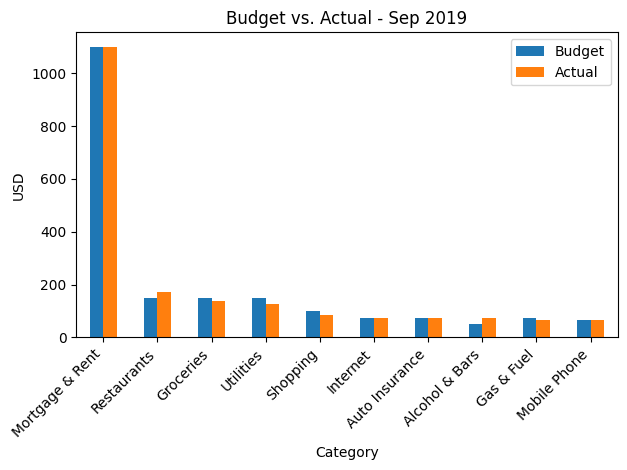

In [ ]:
# Visualize Budget vs. Actual

import matplotlib.pyplot as plt

def plot_budget_vs_actual(rep, title):
  ax = rep.sort_values("Actual", ascending=False).head(10)[["Category", "Budget", "Actual"]].set_index("Category").plot(kind="bar")
  ax.set_title(title); ax.set_ylabel("USD"); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()

rep = month_report("2019-09")
plot_budget_vs_actual(rep, "Budget vs. Actual - Sep 2019")

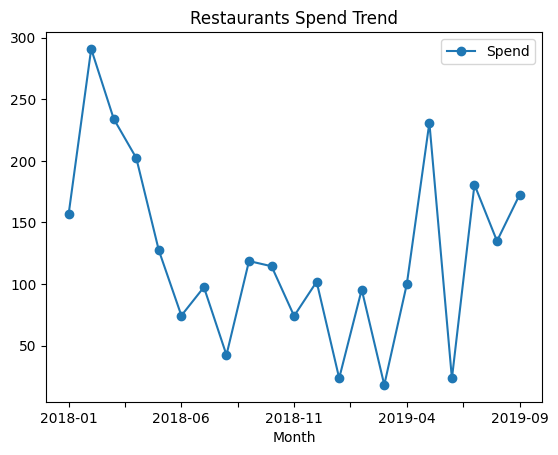

In [ ]:
# Visualize Category Spend

def plot_trend(category):
  cat_tx = tx.groupby("Month")["Spend"].sum().reset_index()
  cat_tx = tx[tx["Category"] == category].groupby("Month")["Spend"].sum().reset_index()
  cat_tx.plot(x="Month", y="Spend", kind="line", marker="o", title=f"{category} Spend Trend")
plot_trend("Restaurants")

In [ ]:
# Add yfinance for investments

import time, yfinance as yf, pandas as pd

def _fetch_one_ticker(ticker, period="1y", interval="1d", retries=2, sleep=1.0):
    for a in range(retries + 1):
        try:
            df = yf.download(ticker, period=period, interval=interval,
                             auto_adjust=False, progress=False, threads=False)
            if df.empty or "Adj Close" not in df: return None
            s = df["Adj Close"].dropna()
            if s.empty: return None
            start = s.iloc[0].item()
            end   = s.iloc[-1].item()
            last_close = df["Close"].dropna().iloc[-1].item()

            ret = (end/start - 1) * 100
            return {"ticker": ticker, "start": start, "end": end,
                    "return_pct": ret, "last_close": last_close}
        except Exception as e:
            if a == retries:
                return {"ticker": ticker, "start": None, "end": None,
                        "return_pct": None, "last_close": None, "error": str(e)}
            time.sleep(sleep)

def stock_summary(tickers="SPY", period="1y", interval="1d"):
    if isinstance(tickers, str): tickers = [tickers]
    rows = [_fetch_one_ticker(t, period, interval) for t in tickers]
    rows = [r for r in rows if r is not None]
    if not rows:
        return pd.DataFrame(columns=["ticker","start","end","return_pct","last_close"])
    return pd.DataFrame(rows).sort_values("return_pct", ascending=False, na_position="last")

In [ ]:
# Define summarize returns

def summarize_returns(results, period_label="1y"):
    print(f"\n--- Investment Summary for {period_label} ---\n")
    if results.empty:
        print("No data available."); return
    bad = results[results["return_pct"].isna()]
    good = results[results["return_pct"].notna()]
    for r in good.itertuples(index=False):
        print(f"{r.ticker}: {r.return_pct:,.2f}% "
              f"(Start ${r.start:,.2f} → End ${r.end:,.2f}; Last ${r.last_close:,.2f})")
    if not bad.empty:
        print("\n Skipped due to fetch error/timeouts:", ", ".join(bad["ticker"].tolist()))

In [ ]:
# Router + helpers

import re
import matplotlib.pyplot as plt

def parse_month(text: str):
    m = re.search(r"(20\d{2}-\d{2})", text)  # YYYY-MM
    return m.group(1) if m else None

def parse_tickers(text: str):
    # grab UPPERCASE tokens 1-5 chars (very naive)
    toks = re.findall(r"\b[A-Z]{1,5}\b", text)
    ignore = {"USD", "ETF", "YTD", "YOY", "Q", "VS"}
    return [t for t in toks if t not in ignore] or None

def parse_period(text, default="1y"):
    m = re.search(r"\b(\d+[dwmy])\b", text.lower())
    if m: return m.group(1)
    if "ytd" in text.lower(): return "ytd"
    return default

def parse_topn(q: str, default=5):
    m = re.search(r"top\s+(\d+)", q.lower())
    return int(m.group(1)) if m else default

def ask(q: str):
    ql = q.lower()

    # ----- Budget -----
    if any(k in ql for k in ["budget","spend","over budget","under budget","variance","category"]):
        month = parse_month(q) or (tx.groupby("Month")["Spend"].sum().pipe(lambda s: s[s>0]).index.max())
        rep = month_report(month)
        display(rep.head(10))
        topn = parse_topn(q, 5)
        budget_summary(rep, top=topn, month_label=human_month(month))
        return

    # ----- Stocks -----
    tickers_found = parse_tickers(q)
    if tickers_found or any(k in ql for k in ["stock","ticker","price","return","market","invest","compare"]):
        tickers = tickers_found or ["SPY"]
        period = parse_period(q, "6m")  # default can be "1y" if you prefer
        results = stock_summary(tickers, period)
        summarize_returns(results, period)
        valid = results[results["return_pct"].notna()]
        if not valid.empty:
            valid.set_index("ticker")["return_pct"].plot(kind="bar", title=f"{period.upper()} Returns (%)")
            plt.ylabel("Return (%)"); plt.xticks(rotation=0); plt.tight_layout(); plt.show()
        return

    # ----- RAG (tips/explain/what is/rule) -----
    if any(k in ql for k in ["how","tips","should i","explain","what is","rule"]):
        print(rag_answer(q, k=3))
        return

    print("Try:\n • Where am I over budget in 2019-09?\n • Compare AAPL and MSFT over 1y\n • How can I reduce restaurant spending?")

,Category,Budget,Actual,Variance
0,Alcohol & Bars,50,72.98,22.98
15,Restaurants,150,172.34,22.34
1,Auto Insurance,75,75.00,0.00
12,Mortgage & Rent,1100,1100.00,0.00
3,Electronics & Software,0,0.00,0.00
11,Mobile Phone,65,65.00,0.00
10,Internet,75,75.00,0.00
13,Movies & DVDs,0,0.00,0.00
14,Music,11,10.69,-0.31
17,Television,15,13.90,-1.10


--- Budget Summary for September 2019 ---

Top 2 over-budget categories:
  - Alcohol & Bars: +$22.98 (Actual $72.98 vs Budget $50.00)
  - Restaurants: +$22.34 (Actual $172.34 vs Budget $150.00)

Top 5 under-budget categories:
  - Home Improvement: $-223.75 (Actual $26.25 vs Budget $250.00)
  - Haircut: $-30.00 (Actual $0.00 vs Budget $30.00)
  - Entertainment: $-25.00 (Actual $0.00 vs Budget $25.00)
  - Utilities: $-25.00 (Actual $125.00 vs Budget $150.00)
  - Fast Food: $-15.00 (Actual $0.00 vs Budget $15.00)

--- Investment Summary for 1y ---

MSFT: 24.29% (Start $410.04 → End $509.64; Last $509.64)
AAPL: 1.68% (Start $228.73 → End $232.56; Last $232.56)


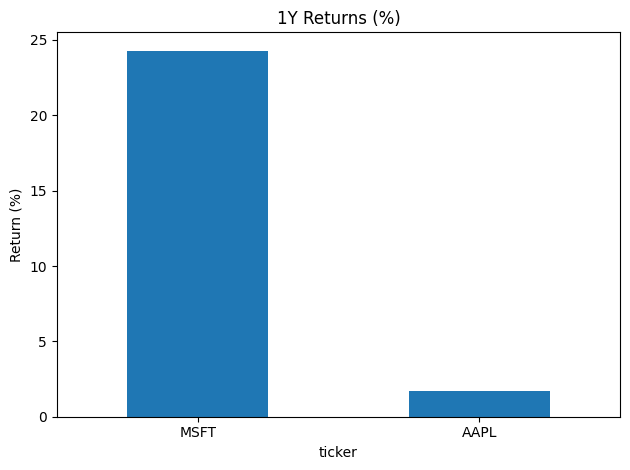

,Category,Budget,Actual,Variance
0,Alcohol & Bars,50,72.98,22.98
15,Restaurants,150,172.34,22.34
1,Auto Insurance,75,75.00,0.00
12,Mortgage & Rent,1100,1100.00,0.00
3,Electronics & Software,0,0.00,0.00
11,Mobile Phone,65,65.00,0.00
10,Internet,75,75.00,0.00
13,Movies & DVDs,0,0.00,0.00
14,Music,11,10.69,-0.31
17,Television,15,13.90,-1.10


--- Budget Summary for September 2019 ---

Top 2 over-budget categories:
  - Alcohol & Bars: +$22.98 (Actual $72.98 vs Budget $50.00)
  - Restaurants: +$22.34 (Actual $172.34 vs Budget $150.00)

Top 5 under-budget categories:
  - Home Improvement: $-223.75 (Actual $26.25 vs Budget $250.00)
  - Haircut: $-30.00 (Actual $0.00 vs Budget $30.00)
  - Entertainment: $-25.00 (Actual $0.00 vs Budget $25.00)
  - Utilities: $-25.00 (Actual $125.00 vs Budget $150.00)
  - Fast Food: $-15.00 (Actual $0.00 vs Budget $15.00)


In [ ]:
ask("Where am I over budget in 2019-09?")
ask("Compare AAPL and MSFT returns over 1y")
ask("What is my total spend last month?")


In [ ]:
# Create knowledge base

%%bash
mkdir -p /content/FinAssist/kb # Create directory if it doesn't exist
cat > /content/FinAssist/kb/finance_guide.md << 'EOF' # Budgeting tips & reference

## 50/30/20 Rule
Allocate 50% needs (rent, utilities), 30% wants (restaurants, entertainment), 20% savings/debt payoff.

## Lowering restaurant spend
- Set a weekly cap and track it.
- Meal prep 2 lunches/wk to cut impulse orders.
- Move coffee/fast food into a shared "Dining Out" cap.

## Groceries vs. Dining
- Groceries up + dining up → overbuying & eating out. Plan meals, shop with list.
- Groceries up + dining down → home cooking trend; check waste/spoilage.

## Mobile & Internet Bills
- Call the provider every 6-12 months for promo pricing.
- Bundle or auto-pay discounts can save 5-15%

## Emergency Fund
- Target 3-6 months expenses. Automate transfers the day after payday.

## Credit Card Payments
- Treat as transfers; don't double count as spend.

## Variance Interpretation
- Variance = Actual - Budget. Positive = over-budget; negative = under.
- Largest positive variance categories are best savings targets.

## Investment Basics
- Diversified index funds for long horizons.
- Compare 1y return to SPY as a quick benchmark.
EOF

In [ ]:
# Create RAG helper module

%%bash
cat > /content/FinAssist/finassist/rag.py << 'EOF'
import os, re, pickle
from typing import List, Tuple
from sentence_transformers import SentenceTransformer
import numpy as np

KB_PATH = "/content/FinAssist/kb/finance_guide.md"
EMB_PATH = "/content/FinAssist/kb/embeddings.pkl"
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

# For the definition-style question
FIFTY_RULE_LINE = (
    "Allocate ~50% to needs, 30% to wants, 20% to savings/debt "
    "(e.g., on $3,000 take-home: $1,500 needs / $900 wants / $600 savings)."
)

SECTION_KEYWORDS = {
    "internet":  {"internet","provider","promo","bundle","auto-pay","autopay","wifi","cable"},
    "mobile":    {"mobile","phone","cell","provider","plan","promo","bundle","auto-pay","autopay"},
    "restaurant":{"restaurant","dining","fast","coffee","cap","track","meal","prep","grocer","groceries"},
    "emergency": {"emergency","fund","3-6","3–6","months","savings","buffer"}
}

DOMAIN_BLOCKLIST = {
    "mobile":    {"restaurant","dining","coffee","fast","meal","prep","grocer","groceries"},
    "internet":  {"restaurant","dining","coffee","fast","meal","prep","grocer","groceries"},
    "emergency": {"internet","provider","promo","bundle","auto-pay","autopay","restaurant","dining","coffee","fast","grocer","groceries"},
}

EMERGENCY_LINE = "Target 3–6 months expenses. Automate transfers the day after payday."
SECTION_KEYWORDS["emergency"] = {"emergency","fund","months","expenses","payday"}


def _load_chunks(path: str, max_len=800) -> List[str]:
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()
    # Split by blank lines so headers stay with their bullets
    blocks = [b.strip() for b in re.split(r"\n\s*\n", text) if b.strip()]

    # Optionally re-pack long blocks into <= max_len chunks
    chunks, buf = [], ""
    for b in blocks:
        if not buf:
            buf = b
        elif len(buf) + 1 + len(b) <= max_len:
            buf = f"{buf}\n{b}"
        else:
            chunks.append(buf)
            buf = b
    if buf:
        chunks.append(buf)
    return chunks

def _embed_chunks(chunks: List[str]):
    model = SentenceTransformer(MODEL_NAME)
    return model.encode(chunks, normalize_embeddings=True, show_progress_bar=False)

def _ensure_index():
    os.makedirs(os.path.dirname(EMB_PATH), exist_ok=True)
    if os.path.exists(EMB_PATH):
        with open(EMB_PATH, "rb") as f:
            data = pickle.load(f)
        if data.get("model") == MODEL_NAME and os.path.exists(KB_PATH):
            return data["chunks"], data["emb"]
    chunks = _load_chunks(KB_PATH)
    emb = _embed_chunks(chunks)
    with open(EMB_PATH, "wb") as f:
        pickle.dump({"chunks": chunks, "emb": emb, "model": MODEL_NAME}, f)
    return chunks, emb

def _search(query: str, k=3) -> List[Tuple[str, float]]:
    chunks, emb = _ensure_index()
    model = SentenceTransformer(MODEL_NAME)
    qv = model.encode([query], normalize_embeddings=True, show_progress_bar=False)[0]
    sims = emb @ qv
    idx = np.argsort(-sims)[:k*3]  # grab more upfront

    # Extra filter: if query has keywords, require them in text
    qwords = set(re.findall(r"[a-z]{3,}", query.lower()))
    key_hits = []
    for i in idx:
        text = chunks[i].lower()
        if any(w in text for w in qwords):   # must overlap with query words
            key_hits.append((chunks[i], float(sims[i])))

    # Fall back to original if filter gives nothing
    if not key_hits:
        key_hits = [(chunks[i], float(sims[i])) for i in idx]

    return key_hits[:k]

def _keywordize(text: str):
    return set(re.findall(r"[a-zA-Z]{3,}", text.lower()))

def _extract_bullets(context: str):
    lines = [ln.strip() for ln in context.splitlines()]
    return [
        ln.lstrip("-• ").strip()
        for ln in lines
        if ln and not ln.startswith("##") and (ln.startswith(("-", "•")) or len(ln) <= 120)
    ]

def _q_terms(q: str):
    ql = q.lower()
    terms = set(re.findall(r"[a-zA-Z]{3,}", ql))
    boost = set()
    for key, kws in SECTION_KEYWORDS.items():
        # boost if either the key OR any synonym appears in the query
        if key in ql or any(w in ql for w in kws):
            boost |= kws
    return terms, boost

def _score_line(line: str, q_terms: set, boost: set):
    lw = set(re.findall(r"[a-zA-Z]{3,}", line.lower()))
    base = len(lw & q_terms)
    b = 1.0 if (lw & boost) else 0.0
    length_bonus = 0.2 if len(line) <= 100 else 0.0
    return base + b + length_bonus

def _dollar_examples(line: str, q: str):
    ql = q.lower()
    if any(k in ql for k in ["restaurant", "dining", "fast food", "coffee"]):
        if "cap" in line or "track" in line:
            return line + " (e.g., set a weekly dining cap of $40–$60 and track spend)."
        if "meal prep" in line:
            return line + " (two lunches/week could save ~$20–$30)."
    if "internet" in ql or "mobile" in ql or "phone" in ql:
        if "promo" in line or "provider" in line:
            return line + " (ask for promo pricing; $5–$20/mo savings is common)."
        if "auto-pay" in line or "bundle" in line:
            return line + " (bundles/auto-pay often save 5–15%, e.g., $5–$15/mo)."
    return line

def _filter_bullets_by_keywords(bullets: list[str], q_terms: set, boost: set, domains: set):
    """
    If a domain is detected (e.g., mobile/internet), first drop bullets containing
    any domain-specific blocked terms (like restaurant/groceries for phone/internet).
    Then require overlap with boost keywords. Back off gradually if that over-filters.
    """
    if not boost:
        return bullets

    # 0) Hard block: domain-specific noise (e.g., dining when asking phone/internet)
    blocked_terms = set()
    for d in domains:
        blocked_terms |= DOMAIN_BLOCKLIST.get(d, set())
    if blocked_terms:
        bullets = [
            ln for ln in bullets
            if not (set(re.findall(r"[a-zA-Z]{3,}", ln.lower())) & blocked_terms)
        ] or bullets  # fallback if everything got removed

    # 1) Strict keep: must contain at least one boost word
    strict = []
    for ln in bullets:
        lw = set(re.findall(r"[a-zA-Z]{3,}", ln.lower()))
        if lw & boost:
            strict.append(ln)
    if strict:
        return strict

    # 2) Backoff: allow query OR boost overlap
    backoff = []
    for ln in bullets:
        lw = set(re.findall(r"[a-zA-Z]{3,}", ln.lower()))
        if (lw & boost) or (lw & q_terms):
            backoff.append(ln)
    return backoff or bullets

    # Strict: require domain words
    strict = []
    for ln in bullets:
        lw = set(re.findall(r"[a-zA-Z]{3,}", ln.lower()))
        if lw & boost:
            strict.append(ln)

    if strict:
        return strict

    # Backoff: allow query OR boost overlap
    backoff = []
    for ln in bullets:
        lw = set(re.findall(r"[a-zA-Z]{3,}", ln.lower()))
        if (lw & boost) or (lw & q_terms):
            backoff.append(ln)

    return backoff or bullets

def _detect_domains(ql: str):
    ql = ql.lower()
    domains = set()
    for key, kws in SECTION_KEYWORDS.items():
        if key in ql or any(w in ql for w in kws):
            domains.add(key)
    return domains

def _make_answer(question: str, context: str, k_keep=5):
    q_terms, boost = _q_terms(question)
    bullets = _extract_bullets(context)
    if not bullets:
        para = context.split("\n\n")[0].strip()
        return para[:600] + ("..." if len(para) > 600 else "")

    # detect domains and apply domain-aware filtering
    domains = _detect_domains(question)
    bullets = _filter_bullets_by_keywords(bullets, q_terms, boost, domains)

    scored = sorted(((ln, _score_line(ln, q_terms, boost)) for ln in bullets),
                    key=lambda t: t[1], reverse=True)

    seen, picked = set(), []
    for ln, _ in scored:
        key = ln.lower()
        if key in seen:
            continue
        seen.add(key)
        picked.append(_dollar_examples(ln, question))
        if len(picked) >= k_keep:
            break

    out = [f"**Answer:** {question.strip()}"]
    out += [f"• {p}" for p in picked]
    out.append("\n_Source: FinAssist KB_")
    return "\n".join(out)

    # Keep only relevant bullets when we know the domain
    bullets = _filter_bullets_by_keywords(bullets, q_terms, boost)

    scored = sorted(
        ((ln, _score_line(ln, q_terms, boost)) for ln in bullets),
        key=lambda t: t[1],
        reverse=True,
    )

    seen, picked = set(), []
    for ln, _ in scored:
        key = ln.lower()
        if key in seen:
            continue
        seen.add(key)
        picked.append(_dollar_examples(ln, question))
        if len(picked) >= k_keep:
            break

    out = [f"**Answer:** {question.strip()}"]
    out += [f"• {p}" for p in picked]
    out.append("\n_Source: FinAssist KB_")
    return "\n".join(out)

def rag_answer(question: str, k: int = 3) -> str:
    ql = question.lower()

    # Special-case definition
    if "50/30/20" in ql:
        return ("**Answer:** What is the 50/30/20 rule?\n"
                f"• {FIFTY_RULE_LINE}\n"
                "\n_Source: FinAssist KB_")

    # Retrieve
    hits = _search(question, k=k)
    if not hits or len(hits) == 0:
        return "I don’t have enough info to answer that."

    # Build answer
    context = "\n\n---\n\n".join([c for c, _ in hits])
    out = _make_answer(question, context, k_keep=5)
    # Defensive: never return None/empty
    if not isinstance(out, str) or not out.strip():
        return "I don’t have enough info to answer that."
    return out

def _search(query: str, k=3) -> List[Tuple[str, float]]:
    chunks, emb = _ensure_index()
    model = SentenceTransformer(MODEL_NAME)
    qv = model.encode([query], normalize_embeddings=True, show_progress_bar=False)[0]
    sims = emb @ qv
    idx = np.argsort(-sims)[:k*3]

    q_terms, boost = _q_terms(query)
    key_hits = []
    for i in idx:
        text = chunks[i].lower()
        if any(t in text for t in q_terms) or any(b in text for b in boost):
            key_hits.append((chunks[i], float(sims[i])))

    if not key_hits:
        # IMPORTANT: fallback so we don't end up with [] and then None upstream
        key_hits = [(chunks[i], float(sims[i])) for i in idx]

    return key_hits[:k]

EOF

In [ ]:
# Import (and reload) RAG + extend router

#import sys, importlib, re
#sys.path.append("/content/FinAssist")  # ensure package path

# after CREATE/UPDATE finassist/rag.py, reload it:
#from finassist import rag as rag_mod
#importlib.reload(rag_mod)
#from finassist.rag import rag_answer

#def parse_period(text, default="1y"):
    #q = text.lower()
    #if "ytd" in q:
        return "ytd"
    #m = re.search(r"\b(\d+)\s*([dwmy])\b", q)  # e.g., 6m, 3y, 10d
    #if not m:
        #return default
    #n, u = m.group(1), m.group(2)
    # yfinance expects 'mo' not 'm'
    #if u == "m":
        #u = "mo"
    #return f"{n}{u}"

#ADVICE_HINTS = {
    "verbs": {"how", "tips", "tricks", "reduce", "lower", "cut", "save", "optimize", "explain"},
    "domains": {"internet", "phone", "mobile", "restaurant", "dining", "fast food", "coffee", "bill", "bills"}
#}

#def looks_like_budget(ql: str) -> bool:
    # treat as a budget report only if there's an explicit month
    # or strong report-y wording (but NOT "explain/what is")
    #has_month = bool(re.search(r"\b20\d{2}-\d{2}\b", ql))  # YYYY-MM
    #strong_report = any(k in ql for k in [
        #"over budget", "under budget", "report", "summary", "category", "spend in"
    #])
    #return has_month or strong_report

#def looks_like_invest(ql: str) -> bool:
    #return any(k in ql for k in ["stock","ticker","price","return","market","invest","compare"])

#def looks_like_advice(ql: str) -> bool:
    # do NOT classify as advice if it looks like budget or invest
    #if looks_like_budget(ql) or looks_like_invest(ql):
        #return False
    #if any(v in ql for v in ADVICE_HINTS["verbs"]):
        #return True
    #if any(d in ql for d in ADVICE_HINTS["domains"]):
        #return True
    #return False

#def parse_topn(q: str, default=5):
    #m = re.search(r"top\s+(\d+)", q.lower())
    #return int(m.group(1)) if m else default

#def ask(q: str):
    #ql = q.lower()

    # definition/explanation
    #if re.search(r"\b(explain|what is|define)\b", ql) and (
        #"variance" in ql or "rule" in ql or "50/30/20" in ql
    #):
        #print(rag_answer(q, k=3))
        #return

    # 1) Budget
    #if looks_like_budget(ql):
        #month = parse_month(q) or (tx.groupby("Month")["Spend"].sum().pipe(lambda s: s[s>0]).index.max())
        #rep = month_report(month)
        #display(rep.head(10))
        #topn = parse_topn(q, 5)
        #budget_summary(rep, top=topn, month_label=human_month(month))
        #return

    # 2) Investments
    #if looks_like_invest(ql):
        #tickers = parse_tickers(q) or ["SPY"]
        #period = parse_period(q, "6mo")
        #results = stock_summary(tickers, period)
        #summarize_returns(results, period)
        #if not os.environ.get("FINASSIST_NO_PLOTS"):
            #valid = results[results["return_pct"].notna()]
            #if not valid.empty:
                #valid.set_index("ticker")["return_pct"].plot(kind="bar", title=f"{period.upper()} Returns (%)")
                #plt.ylabel("Return (%)"); plt.xticks(rotation=0); plt.tight_layout(); plt.show()
        #return

    # 3) Advice / RAG last
    #if looks_like_advice(ql):
        #print(rag_answer(q, k=3))
        #return

    #print("Try:\n • Where am I over budget in 2019-09?\n • Compare AAPL and MSFT over 1y\n • How can I reduce restaurant spending?")

In [ ]:
from finassist.cli import ask

In [ ]:
# Quick Test

print(rag_answer("What is the 50/30/20 rule?"))
print()
print(rag_answer("Any tips to lower my internet bill?"))
print()
print(rag_answer("How can I reduce restaurant spending?"))
print()
print(rag_answer("How can I lower my phone bill?"))
print()

**Answer:** What is the 50/30/20 rule?
• Allocate ~50% to needs, 30% to wants, 20% to savings/debt (e.g., on $3,000 take-home: $1,500 needs / $900 wants / $600 savings).

_Source: FinAssist KB_

**Answer:** Any tips to lower my internet bill?
• Call the provider every 6-12 months for promo pricing. (ask for promo pricing; $5–$20/mo savings is common).
• Bundle or auto-pay discounts can save 5-15% (bundles/auto-pay often save 5–15%, e.g., $5–$15/mo).

_Source: FinAssist KB_

**Answer:** How can I reduce restaurant spending?
• Set a weekly cap and track it. (e.g., set a weekly dining cap of $40–$60 and track spend).
• Meal prep 2 lunches/wk to cut impulse orders.
• Move coffee/fast food into a shared "Dining Out" cap. (e.g., set a weekly dining cap of $40–$60 and track spend).
• Groceries up + dining up → overbuying & eating out. Plan meals, shop with list.
• Groceries up + dining down → home cooking trend; check waste/spoilage.

_Source: FinAssist KB_

**Answer:** How can I lower my pho

In [ ]:
# Ask more sample questions

ask("How big should my emergency fund be?")
ask("Show me my top 3 over-budget categories in 2019-09")
ask("Compare TSLA vs SPY over 6m")
ask("Explain variance in budgeting")

**Answer:** How big should my emergency fund be?
• Target 3-6 months expenses. Automate transfers the day after payday.

_Source: FinAssist KB_


,Category,Budget,Actual,Variance
0,Alcohol & Bars,50,72.98,22.98
15,Restaurants,150,172.34,22.34
1,Auto Insurance,75,75.00,0.00
12,Mortgage & Rent,1100,1100.00,0.00
3,Electronics & Software,0,0.00,0.00
11,Mobile Phone,65,65.00,0.00
10,Internet,75,75.00,0.00
13,Movies & DVDs,0,0.00,0.00
14,Music,11,10.69,-0.31
17,Television,15,13.90,-1.10


--- Budget Summary for September 2019 ---

Top 2 over-budget categories:
  - Alcohol & Bars: +$22.98 (Actual $72.98 vs Budget $50.00)
  - Restaurants: +$22.34 (Actual $172.34 vs Budget $150.00)

Top 3 under-budget categories:
  - Home Improvement: $-223.75 (Actual $26.25 vs Budget $250.00)
  - Haircut: $-30.00 (Actual $0.00 vs Budget $30.00)
  - Entertainment: $-25.00 (Actual $0.00 vs Budget $25.00)

--- Investment Summary for 6mo ---

TSLA: 18.09% (Start $292.98 → End $345.98; Last $345.98)
SPY: 9.87% (Start $590.65 → End $648.92; Last $648.92)
**Answer:** Explain variance in budgeting
• Variance = Actual - Budget. Positive = over-budget; negative = under.
• Largest positive variance categories are best savings targets.
• Diversified index funds for long horizons.
• Compare 1y return to SPY as a quick benchmark.

_Source: FinAssist KB_


In [ ]:
# ==== Minimal Gradio wrapper for existing ask() ====
import gradio as gr, io, contextlib, traceback, os

# disable plotting when inside Gradio (plots won't appear in chat)
os.environ["FINASSIST_NO_PLOTS"] = "1"

def handle_message(message, history):
    buf = io.StringIO()
    try:
        with contextlib.redirect_stdout(buf):
            ask(message)  # your existing function that prints
    except Exception as e:
        tb = traceback.format_exc(limit=2)
        return f"Sorry, I hit an error:\n{e}\n\n```\n{tb}\n```"
    out = buf.getvalue().strip()
    return out or "(No output)"

demo = gr.ChatInterface(
    fn=handle_message,
    type="messages",  # <-- fixes the deprecation warning
    title="FinAssist (demo)",
    description="Ask about your budget (e.g., 'Where am I over budget in 2019-09?'), investments ('Compare AAPL & MSFT over 1y'), or tips ('Any ways to lower internet bill?').",
)

demo.launch(share=True, debug=True)  # debug=True shows errors in Colab cell

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://7a2e0aabfcb3743aa4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
